In [20]:
import os
import torch
import numpy as np

from transforms import PrepareEmbeddings, EmbeddingsLoader, ToOneHotTensor, ToTensor
import datasets

## Loading and Preparing Embeddings

### Parameters and Settings

In [21]:
# Set if to load or create new embeddings
# User can change these parameters
LOAD = True # True implies we load from cache instead of creating new cache
mode = 0 # 0: embedding shape (batch size x 1024); 1: embedding shape (batch size x 8 x 1024)

paths = {
    "val":"aist4010-spring2024-a2/data/val.fasta",
    "test":"aist4010-spring2024-a2/data/test.fasta",
    "train":"aist4010-spring2024-a2/data/train.fasta",
}
cache_root = "cache_2" if mode==1 else "cache" # path that the cache is stored

### Functions

In [22]:
# Avoid changing the following code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_cache_path = lambda key: os.path.join(cache_root, f"cache_{key}.csv")

num_classes = len(datasets.arg_dict)
the_datasets = dict()

if not LOAD:
    preparation = PrepareEmbeddings()
    encoder_loaded = None

In [23]:
if not LOAD:
    for key, inp_file in paths.items():
        the_datasets.update({key: preparation.prepare_embeddings(input_file=inp_file, encoder_loaded=encoder_loaded, output_file=get_cache_path(key), is_test=(key=="test"), mode=mode)})

In [24]:
loaded_datasets = dict()

transform = ToTensor()
target_transform = ToOneHotTensor(num_classes=num_classes)

if LOAD:
    loader = EmbeddingsLoader()
    for key, inp_file in paths.items():
        is_test = key=="test"
        loaded_datasets.update({key: loader.load_embeddings(input_file=get_cache_path(key), is_test=is_test, transform=transform, 
                                                            target_transform=target_transform if not is_test else None, mode=mode)})

    the_datasets = loaded_datasets

## Setting Up DataLoaders and Training Environment

### Parameters and Settings

In [25]:

epoch = 0

LOAD_PATH = None
COMBINE_TRAIN = False
INNER_LOG_DISPLAY = False

In [26]:
# User can set these parameters
batch_size = 128#64

INITIAL_LR = 1e-3
GAMMA = .995
#GAMMA = .99
#GAMMA = .975

OPTIMIZER = torch.optim.Adam
DECAY_METHOD = torch.optim.lr_scheduler.ExponentialLR

NUM_EPOCHS = 2500
NUM_EPOCHS_TO_SAVE = 100

INP_DIM = 8*1024 if mode==1 else 1024

In [27]:
from models import FCNet
#model = FCNet(hidden=[1024, 256, 256, num_classes])
#model = FCNet(hidden=[1024, 256, num_classes])
model = FCNet(hidden=[1024, 512, 256, num_classes], mode=mode)
#model = FCNet(hidden=[1024, 512, 256, 128, num_classes])
#model = FCNet(hidden=[8*1024, 512, 256, num_classes])
#model = FCNet(hidden=[8*1024, 512, num_classes])
#model = FCNet(hidden=[8*1024, 512, 256, 128, num_classes])
#model = FCNet(hidden=[8*1024, 512, 512, num_classes])

### Functions

In [28]:
import time
TRAIN_ID = int(time.time())

In [29]:
training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []
lrs = []

In [30]:
# Avoid changing the following code
from torch.utils.data import DataLoader, ConcatDataset
from libs import *

if COMBINE_TRAIN:
    composed_dataset = ConcatDataset([the_datasets["train"], the_datasets["val"]])
    train_loader = DataLoader(composed_dataset, batch_size=batch_size, shuffle=True)
else:
    train_loader = DataLoader(the_datasets["train"], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(the_datasets["val"], batch_size=batch_size)
test_loader = DataLoader(the_datasets["test"], batch_size=batch_size)

### Training
Start here to continue training.

In [31]:
load_model(model, LOAD_PATH, device=device)
loss_fn, opt, scheduler = set_optimizers(model, loss_fn=nn.CrossEntropyLoss, optimizer=OPTIMIZER, lr=INITIAL_LR, decay=DECAY_METHOD, gamma=GAMMA)

In [32]:
def train_(epochs:int=100, inner_log:bool=False):
    global epoch, training_losses, validation_losses, training_accuracy, validation_accuracy, lrs
    
    if not inner_log:
        print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)

    rng = tqdm(range(epochs)) if not inner_log else range(epochs)
    
    for t in rng:
        if inner_log:
            print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)
        loss, train_accuracy, lr = train(train_loader, model, loss_fn, opt, scheduler=scheduler, device=device, log=inner_log)
        val_loss, val_accuracy = test(val_loader, model, loss_fn, device=device, log=inner_log)
        training_losses.append(loss)
        validation_losses.append(val_loss)
        training_accuracy.append(train_accuracy)
        validation_accuracy.append(val_accuracy)
        lrs.append(lr)
        epoch += 1
    
    print(f" Train accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {loss:>8f}, lr: {lr}")
    print(f" Test accuracy: {(100*val_accuracy):>0.1f}%, Avg loss: {val_loss:>8f}")

In [33]:
def plot(PTH):
    plt.plot(training_accuracy, label=f'Train Accuracy\nLast: {training_accuracy[-1]}')
    plt.plot(validation_accuracy, label=f'Test Accuracy\nLast: {validation_accuracy[-1]}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_accs.png')
    plt.show()

    plt.plot(training_losses, label=f'Train Loss\nLast: {training_losses[-1]}')
    plt.plot(validation_losses, label=f'Test Loss\nLast: {validation_losses[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_losses.png')
    plt.show()

    plt.plot(lrs, label=f'Lrs\nFinal: {lrs[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_lrs.png')
    plt.show()

### Training


 =============== Epoch 1 ===============


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

 Train accuracy: 99.9%, Avg loss: 0.001196, lr: 0.0006088145090359073
 Test accuracy: 98.0%, Avg loss: 0.214109


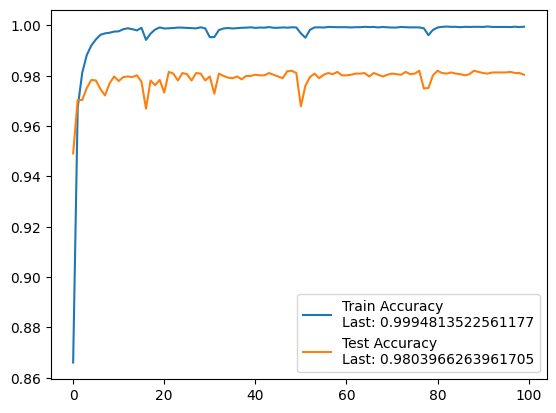

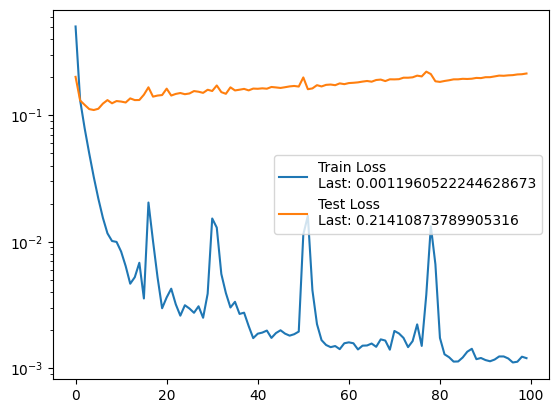

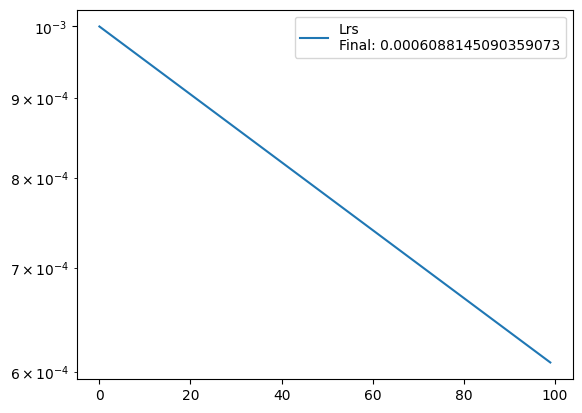


 =============== Epoch 101 ===============


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]

 Train accuracy: 99.9%, Avg loss: 0.000845, lr: 0.00036880183088056984
 Test accuracy: 98.1%, Avg loss: 0.272649


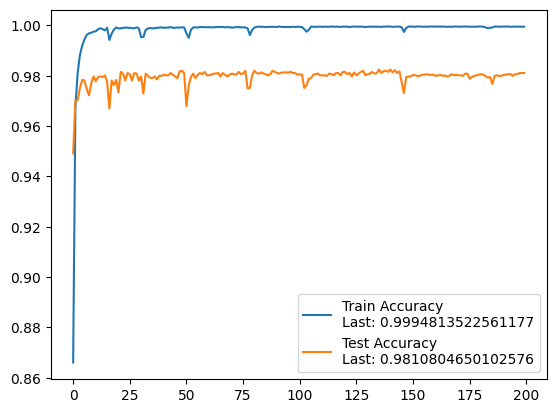

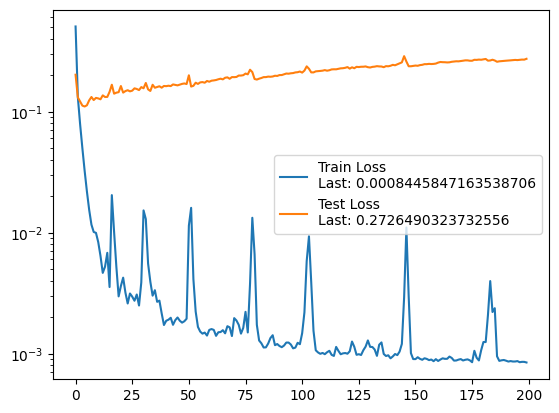

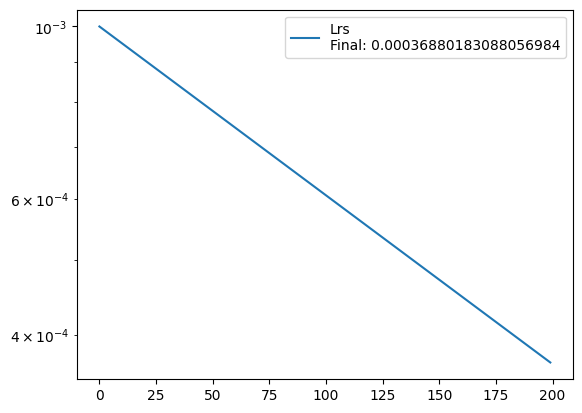


 =============== Epoch 201 ===============


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]

 Train accuracy: 100.0%, Avg loss: 0.000826, lr: 0.00022340924607110228
 Test accuracy: 98.1%, Avg loss: 0.365693


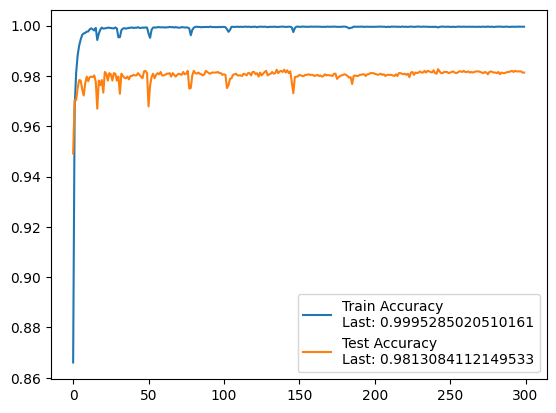

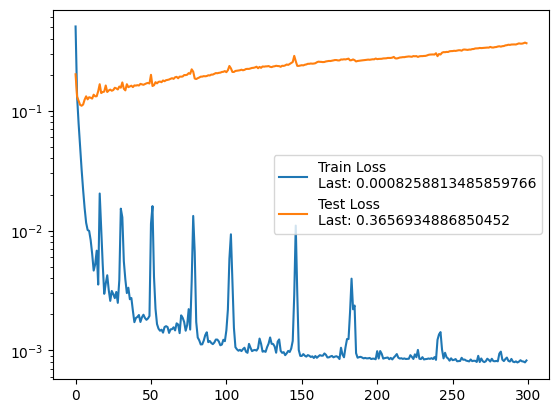

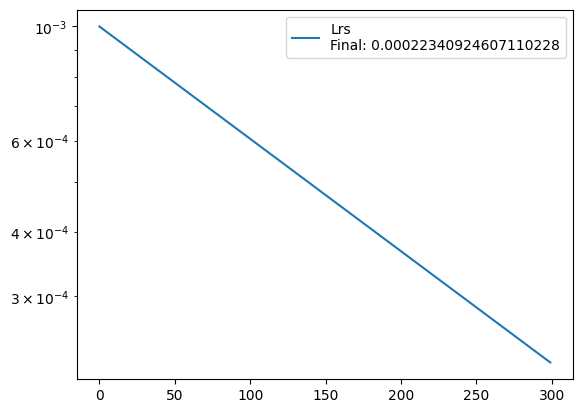


 =============== Epoch 301 ===============


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

 Train accuracy: 100.0%, Avg loss: 0.000711, lr: 0.00013533471650855608
 Test accuracy: 98.2%, Avg loss: 0.441160


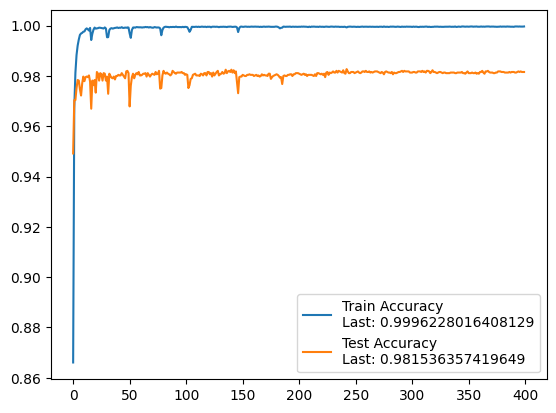

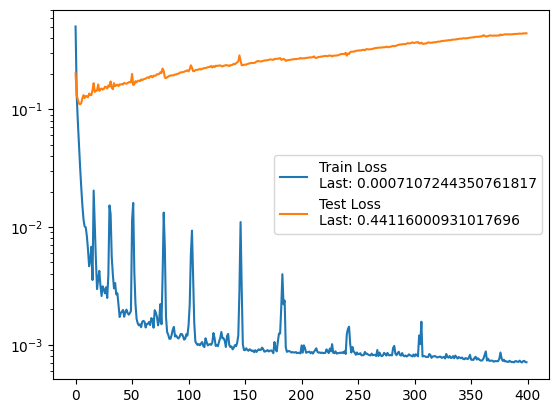

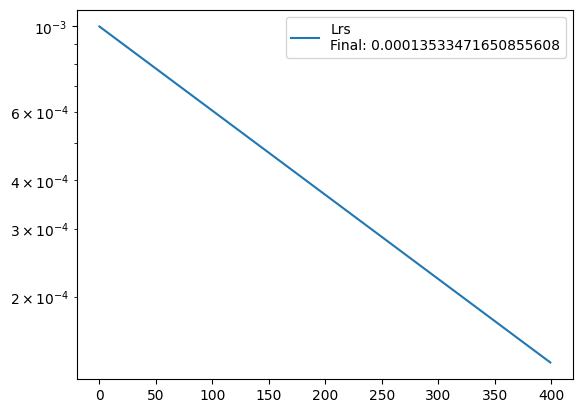


 =============== Epoch 401 ===============


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

 Train accuracy: 100.0%, Avg loss: 0.000633, lr: 8.19817702917369e-05
 Test accuracy: 98.1%, Avg loss: 0.502996


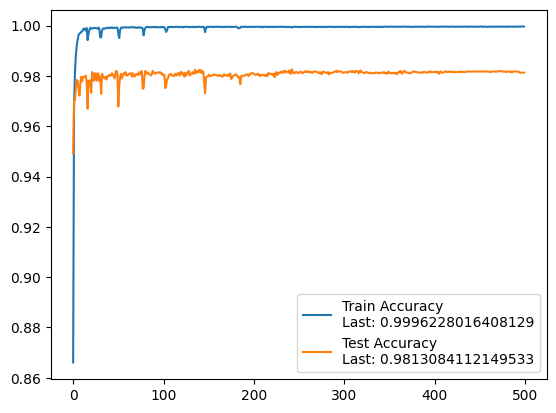

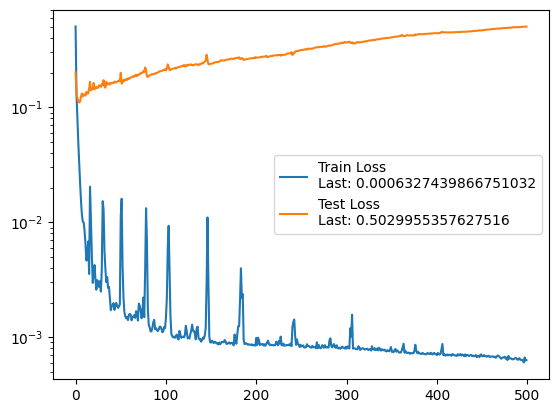

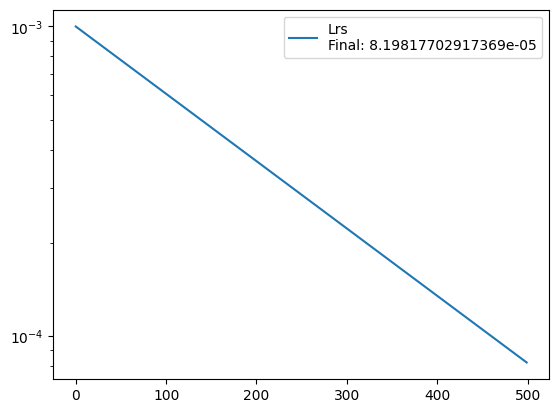


 =============== Epoch 501 ===============


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]

 Train accuracy: 100.0%, Avg loss: 0.000523, lr: 4.966213277390809e-05
 Test accuracy: 98.1%, Avg loss: 0.544461


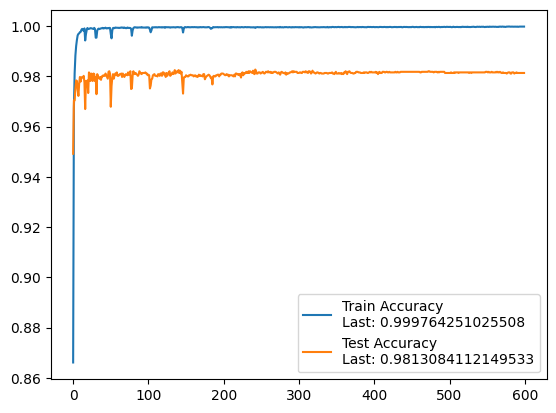

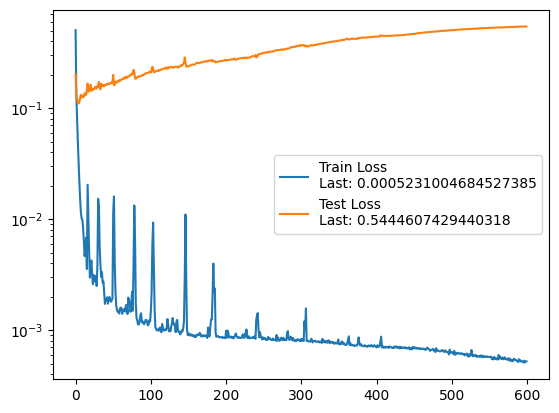

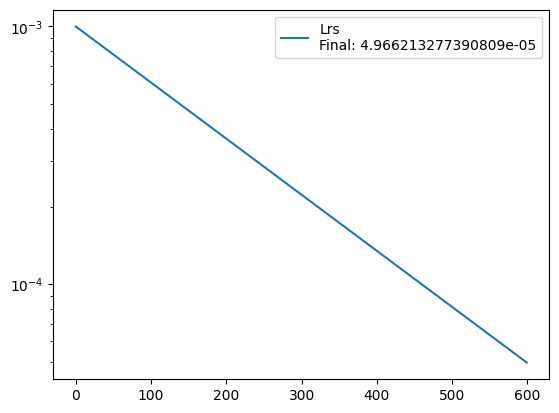


 =============== Epoch 601 ===============


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

 Train accuracy: 100.0%, Avg loss: 0.000456, lr: 3.0083851847510787e-05
 Test accuracy: 98.1%, Avg loss: 0.568327


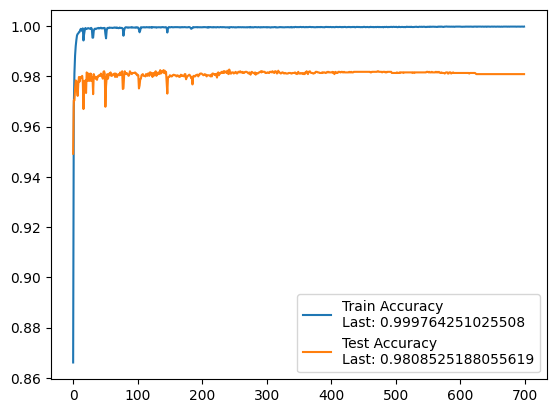

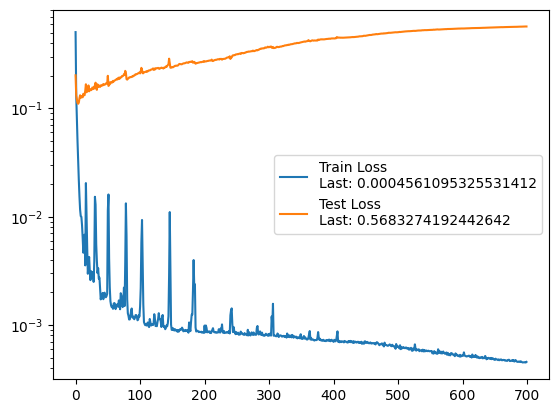

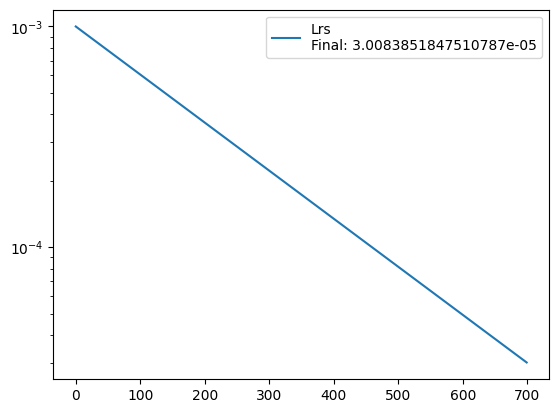


 =============== Epoch 701 ===============


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]

 Train accuracy: 100.0%, Avg loss: 0.000408, lr: 1.822390806498899e-05
 Test accuracy: 98.1%, Avg loss: 0.585225


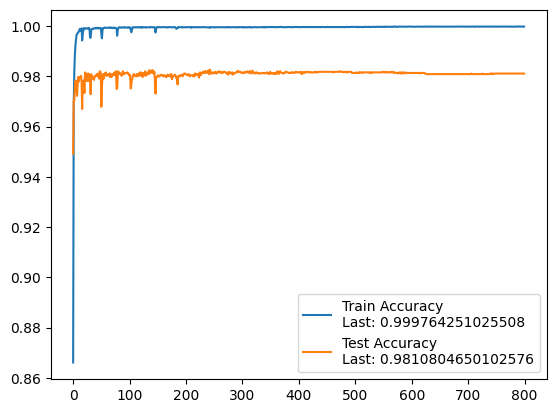

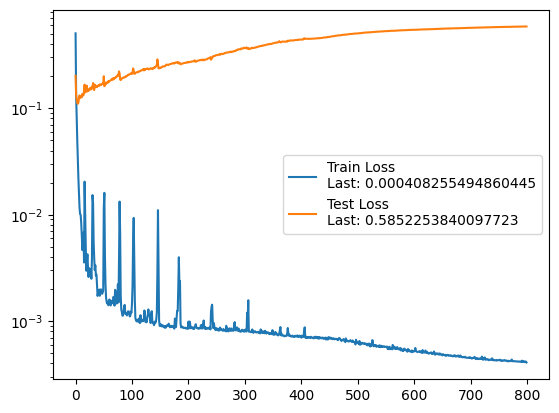

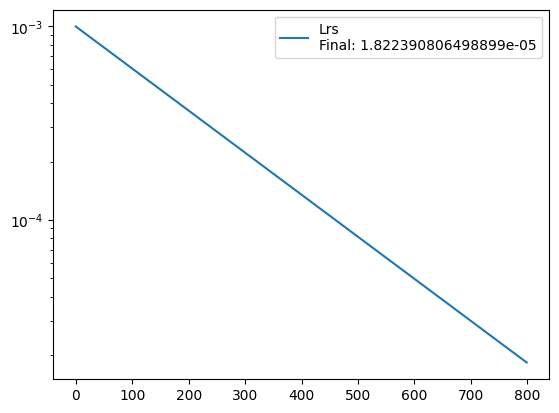


 =============== Epoch 801 ===============


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

 Train accuracy: 100.0%, Avg loss: 0.000391, lr: 1.1039504743095277e-05
 Test accuracy: 98.1%, Avg loss: 0.596865


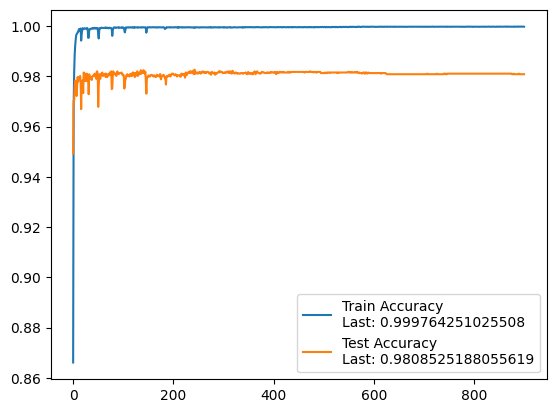

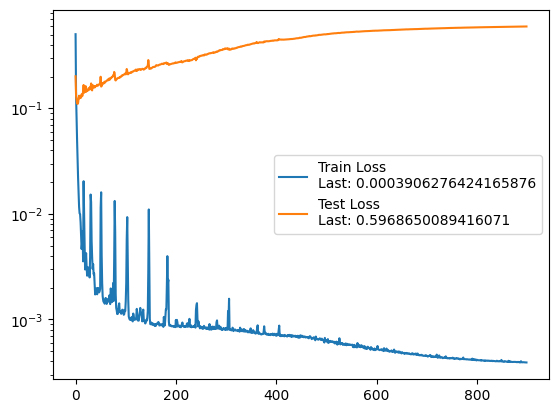

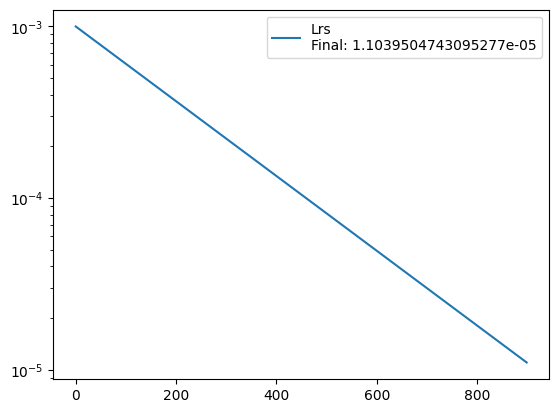


 =============== Epoch 901 ===============


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

 Train accuracy: 100.0%, Avg loss: 0.000369, lr: 6.687405606866292e-06
 Test accuracy: 98.1%, Avg loss: 0.605294


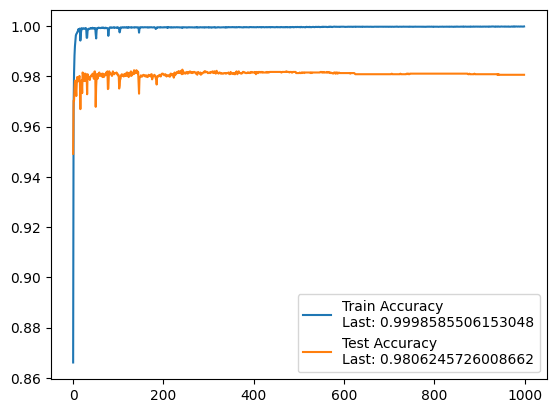

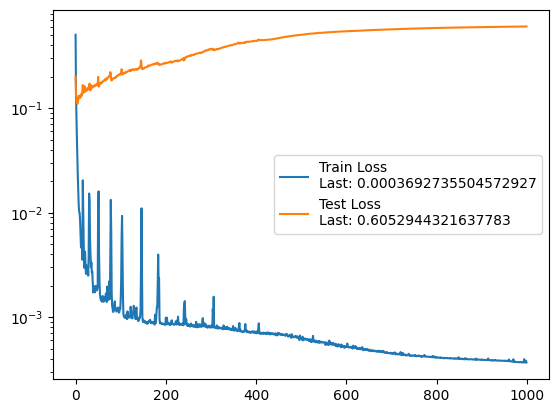

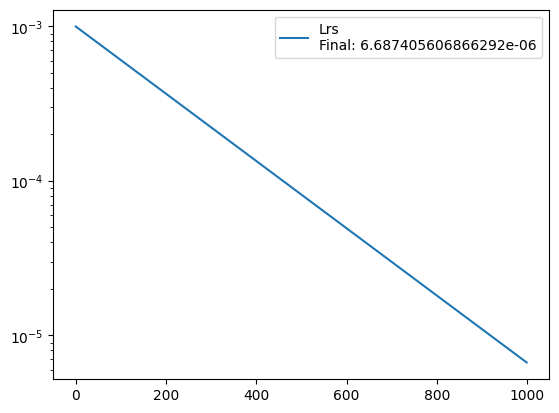


 =============== Epoch 1001 ===============


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]

 Train accuracy: 100.0%, Avg loss: 0.000360, lr: 4.051032613461934e-06
 Test accuracy: 98.1%, Avg loss: 0.610650


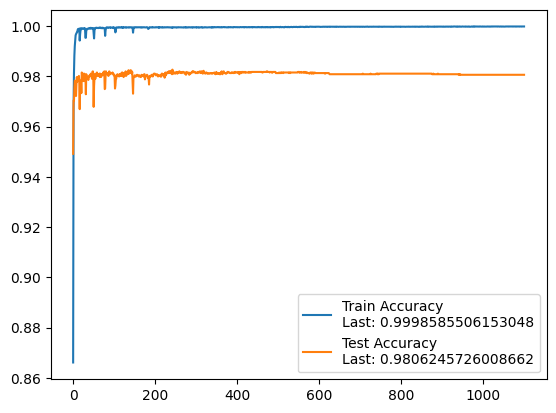

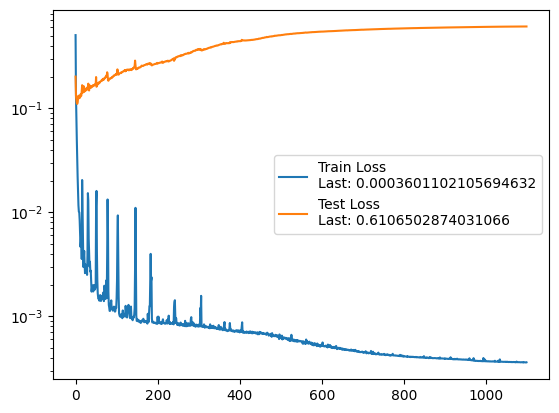

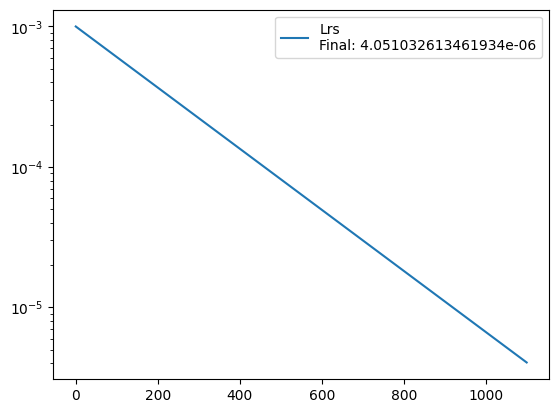


 =============== Epoch 1101 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000354, lr: 2.4539957944950098e-06
 Test accuracy: 98.1%, Avg loss: 0.613936


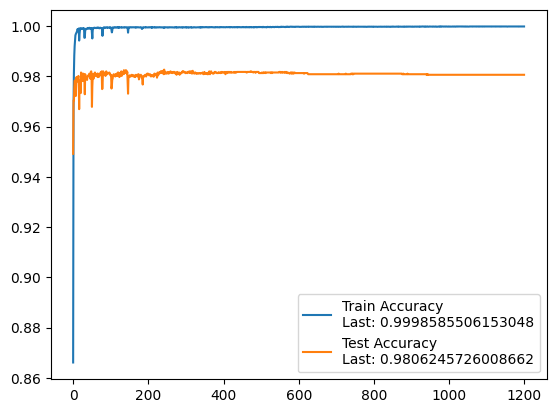

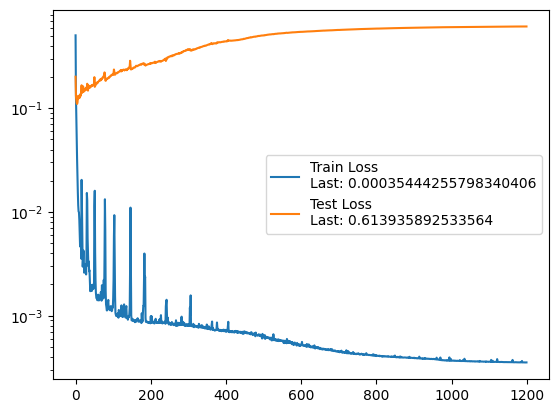

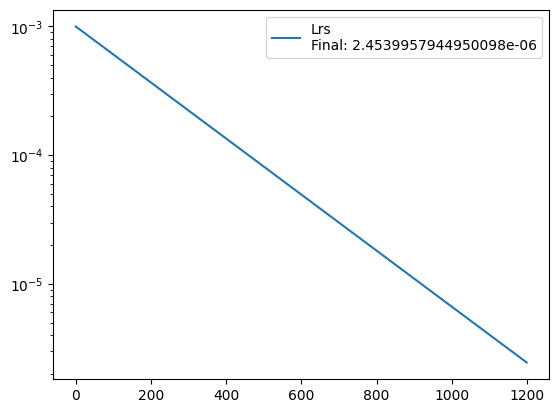


 =============== Epoch 1201 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000352, lr: 1.4865581035776526e-06
 Test accuracy: 98.0%, Avg loss: 0.615789


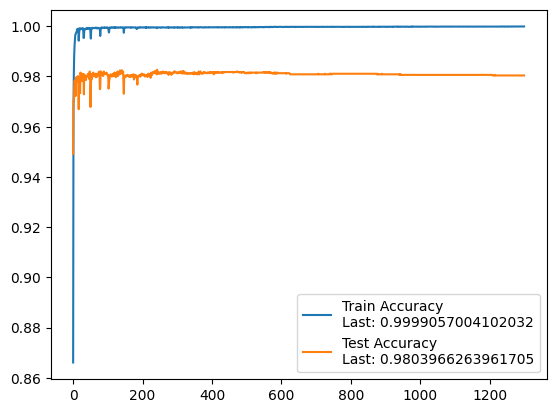

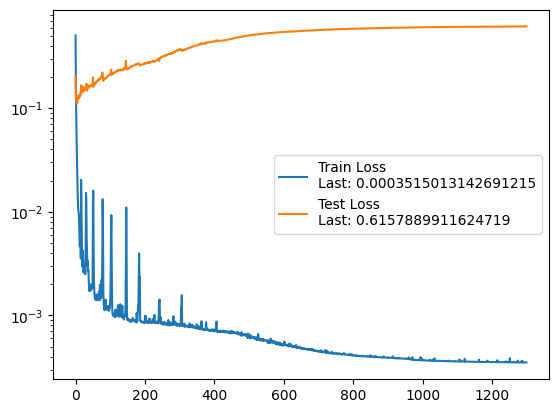

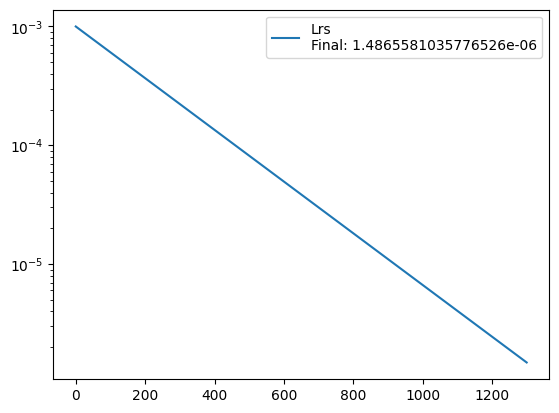


 =============== Epoch 1301 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000350, lr: 9.005129512730631e-07
 Test accuracy: 98.0%, Avg loss: 0.616990


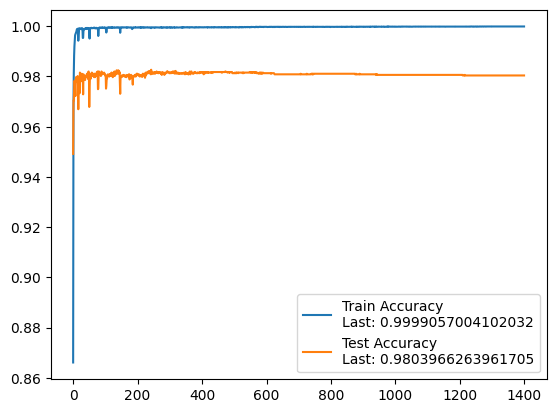

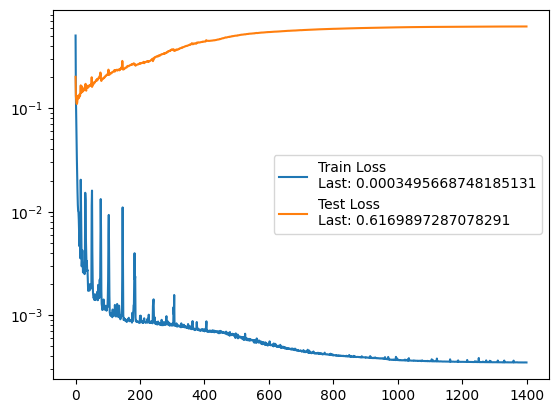

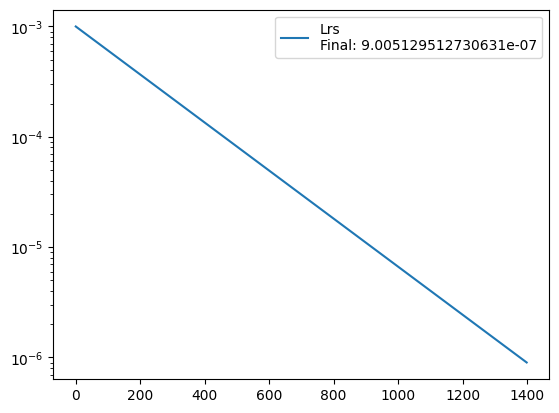


 =============== Epoch 1401 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000348, lr: 5.45504123558237e-07
 Test accuracy: 98.0%, Avg loss: 0.617705


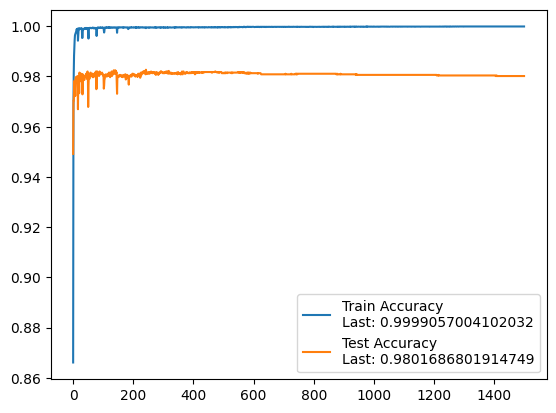

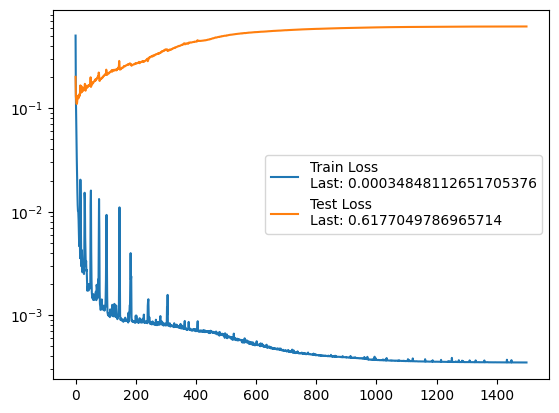

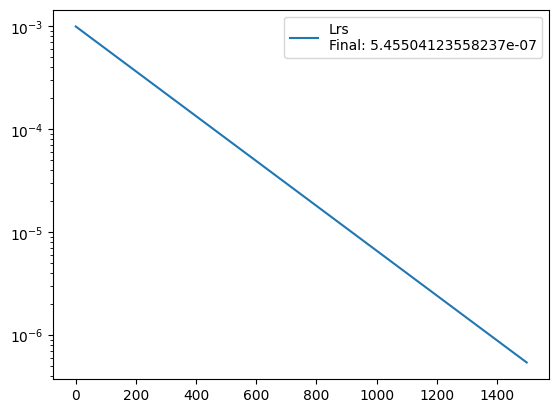


 =============== Epoch 1501 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000348, lr: 3.304502710353649e-07
 Test accuracy: 98.0%, Avg loss: 0.618132


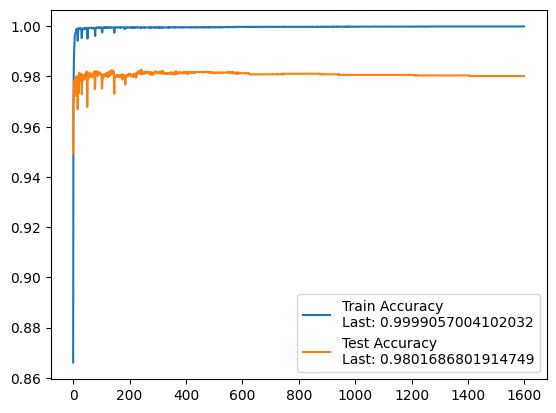

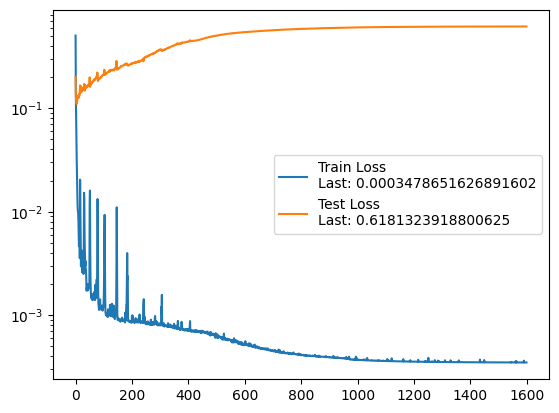

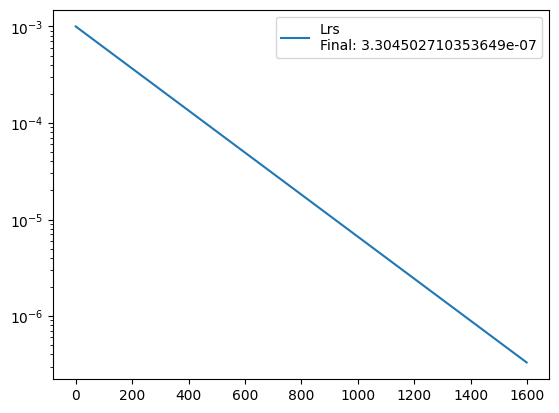


 =============== Epoch 1601 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 2.0017700492357237e-07
 Test accuracy: 98.0%, Avg loss: 0.618385


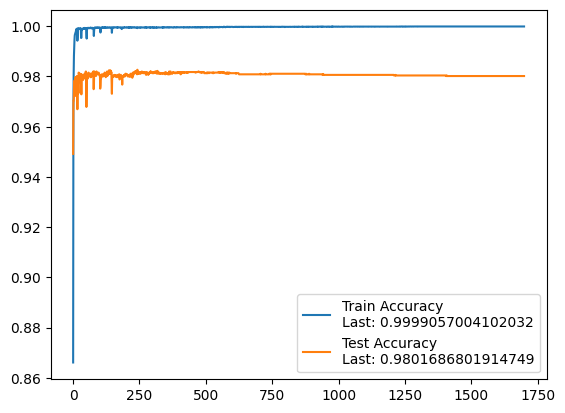

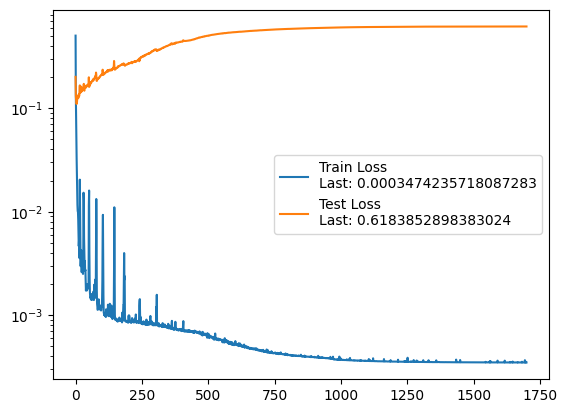

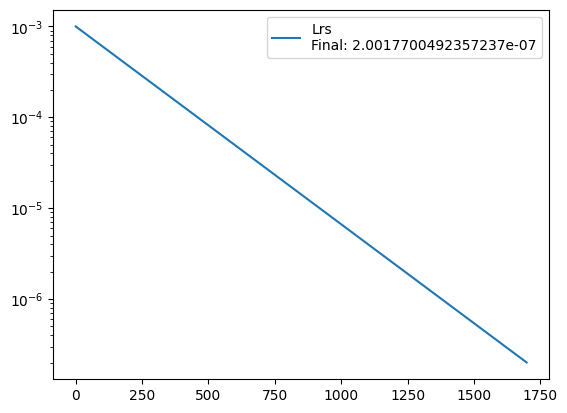


 =============== Epoch 1701 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 1.2126131164795906e-07
 Test accuracy: 98.0%, Avg loss: 0.618540


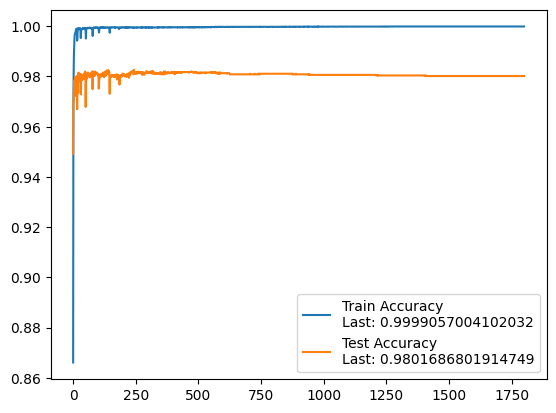

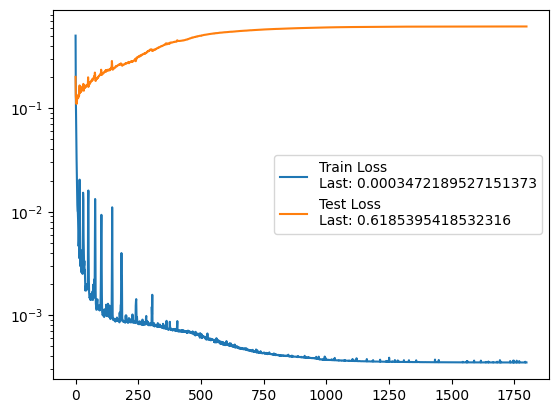

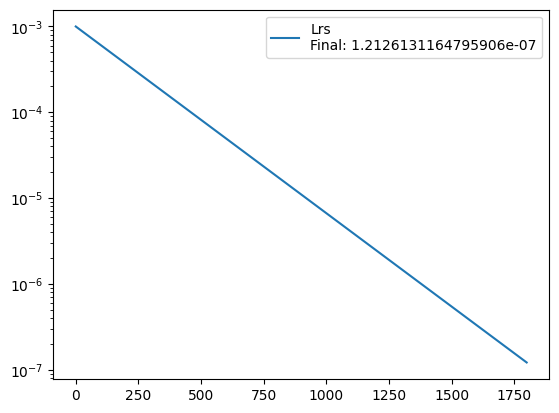


 =============== Epoch 1801 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 7.345651768642233e-08
 Test accuracy: 98.0%, Avg loss: 0.618633


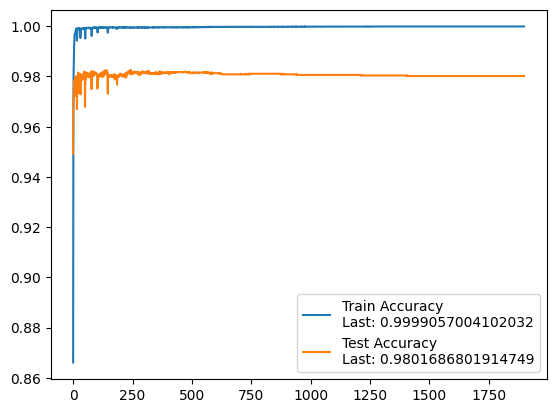

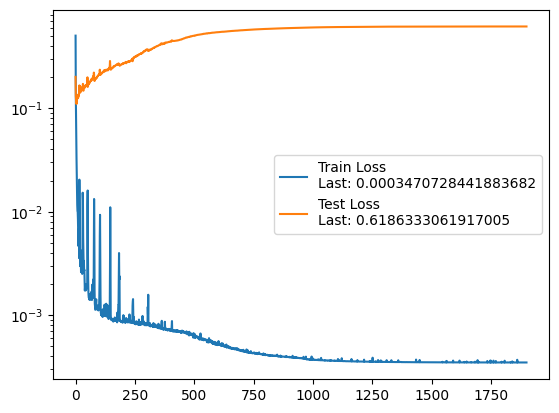

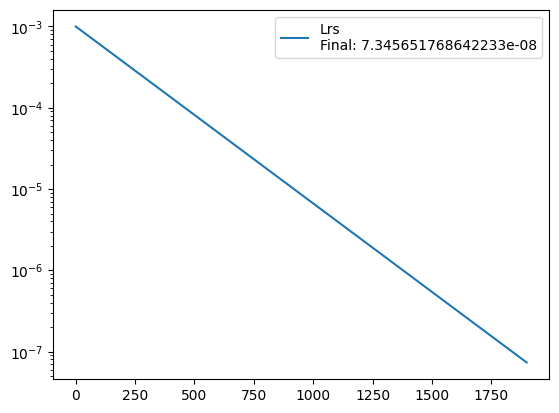


 =============== Epoch 1901 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 4.449778678199293e-08
 Test accuracy: 98.0%, Avg loss: 0.618696


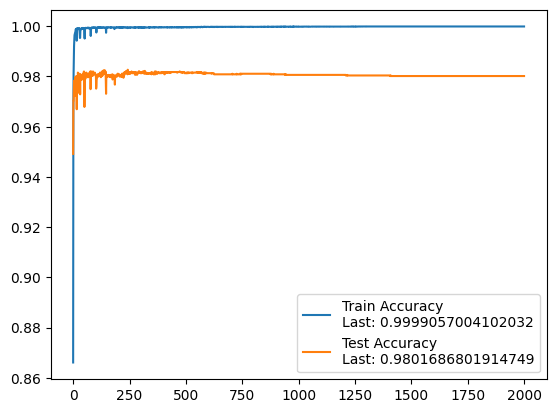

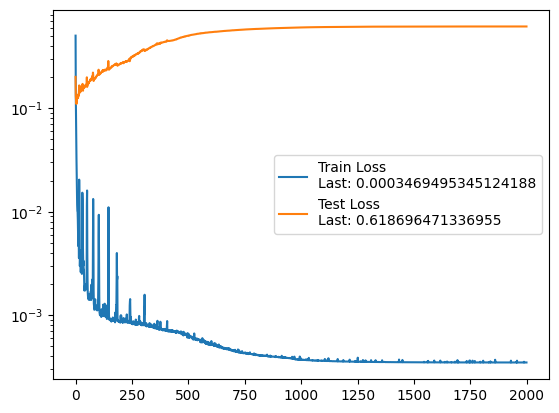

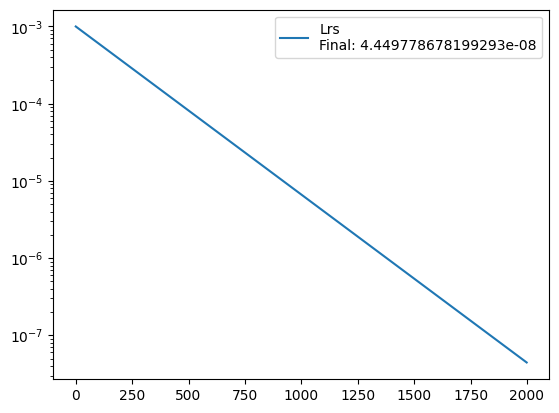


 =============== Epoch 2001 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 2.6955443721799206e-08
 Test accuracy: 98.0%, Avg loss: 0.618735


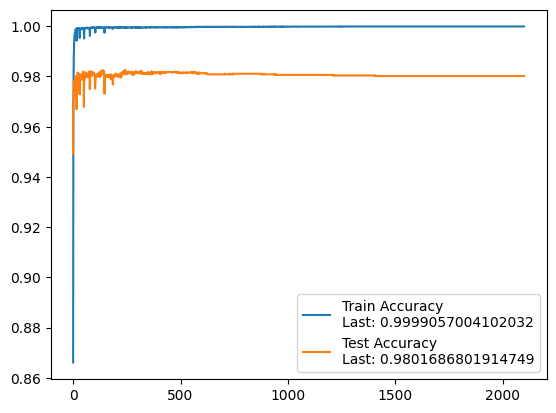

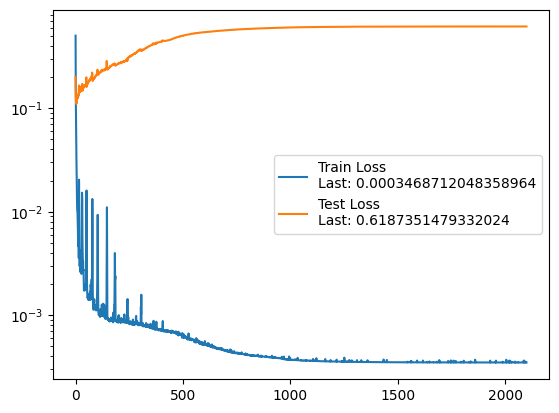

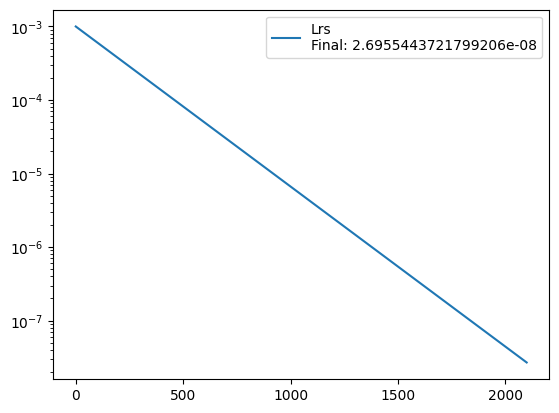


 =============== Epoch 2101 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 1.6328810909155564e-08
 Test accuracy: 98.0%, Avg loss: 0.618758


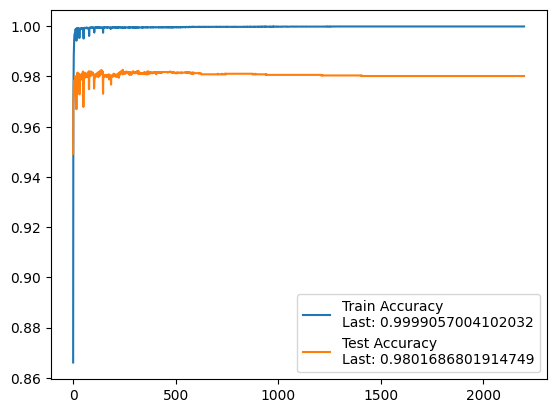

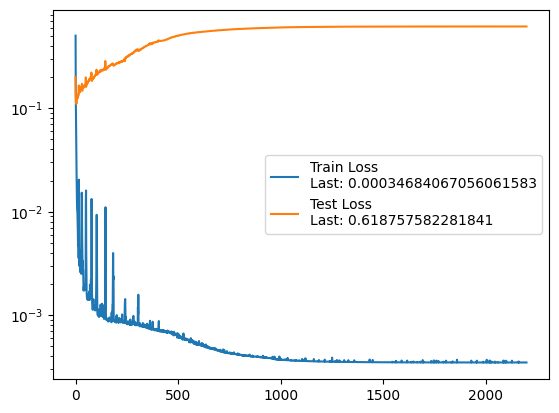

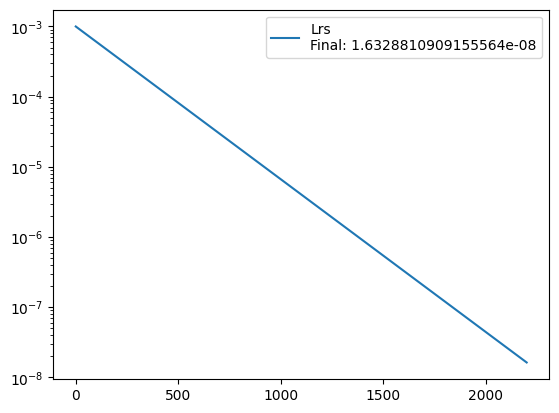


 =============== Epoch 2201 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 9.891510911813719e-09
 Test accuracy: 98.0%, Avg loss: 0.618771


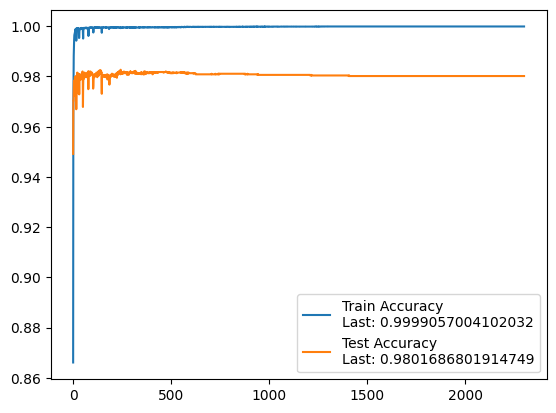

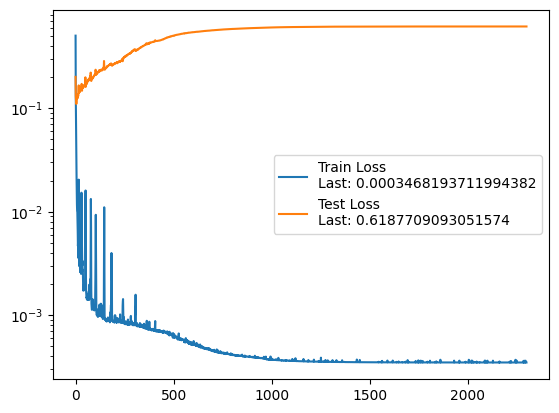

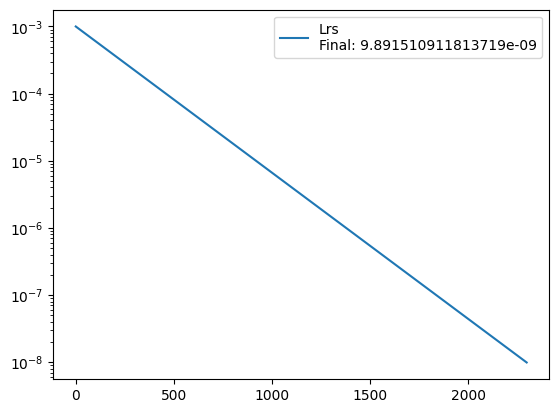


 =============== Epoch 2301 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 5.9919848826021916e-09
 Test accuracy: 98.0%, Avg loss: 0.618779


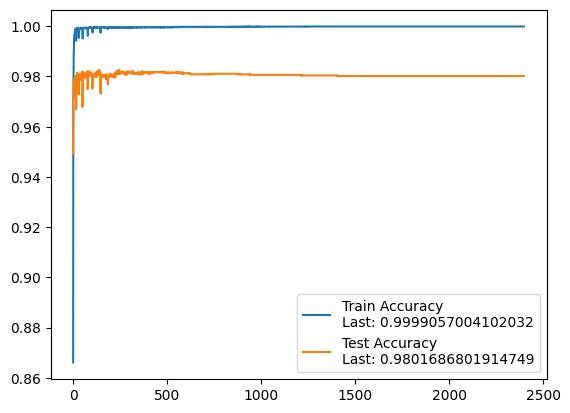

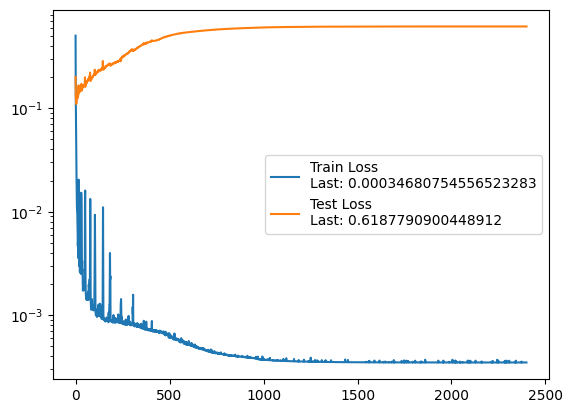

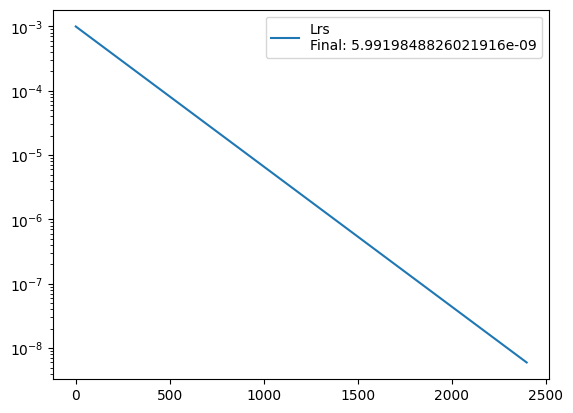


 =============== Epoch 2401 ===============


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

 Train accuracy: 100.0%, Avg loss: 0.000347, lr: 3.629767297779775e-09
 Test accuracy: 98.0%, Avg loss: 0.618784


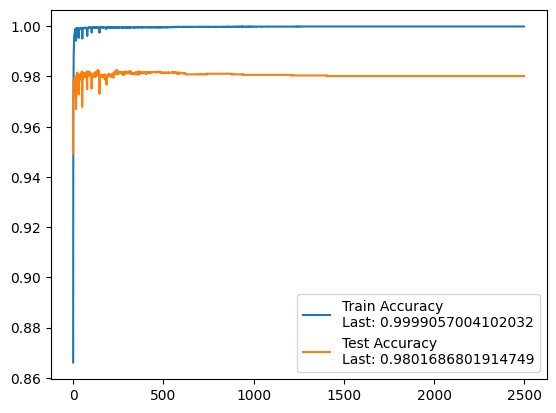

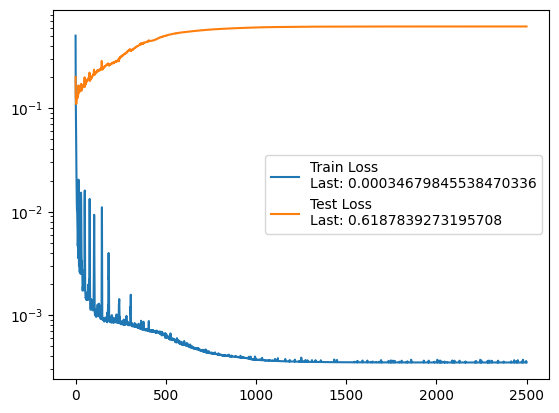

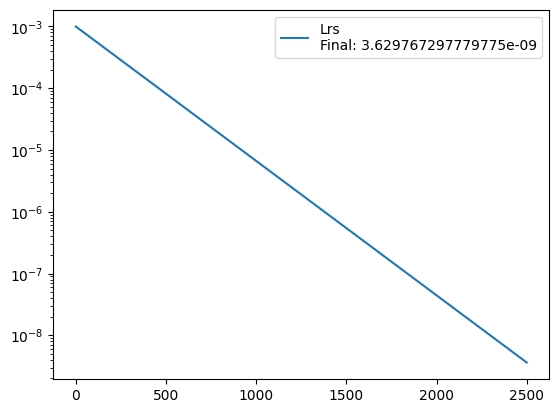

In [34]:
for i in range(NUM_EPOCHS//NUM_EPOCHS_TO_SAVE):
    train_(epochs=NUM_EPOCHS_TO_SAVE, inner_log=INNER_LOG_DISPLAY)
    STORE_PATH = save(os.path.join(str(TRAIN_ID), f'{epoch}'), model, training_accuracy, training_losses, validation_accuracy, validation_losses, lrs)
    plot(STORE_PATH)

### Generating Outputs

In [35]:
import pandas as pd

In [36]:
import importlib
import libs
importlib.reload(libs)

<module 'libs' from 'c:\\kht\\ai\\AI Projects (Local)\\asm2 protein\\libs.py'>

In [37]:
names, predictions = libs.gen_output(test_loader, model, device=device)

100%|██████████| 35/35 [00:00<00:00, 564.49it/s]


In [38]:
outputs = pd.DataFrame({'id':names, 'label':predictions})
print(outputs)
outputs.to_csv(f"{STORE_PATH[:-3]}_submission.csv", index=False)

           id  label
0        SEQ0      0
1        SEQ1     14
2        SEQ2     11
3        SEQ3     14
4        SEQ4     10
...       ...    ...
4464  SEQ4464      1
4465  SEQ4465      5
4466  SEQ4466     11
4467  SEQ4467     14
4468  SEQ4468      9

[4469 rows x 2 columns]
